In [15]:
# Basics
import numpy as np
import random
from tensorflow.keras.models import load_model

# Custom
import sys
sys.path.insert(0, '../../src/utils')
from data_loader import DataLoader, SplitDataLoader
import constants
import aes

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [16]:
TARGET = 'SBOX_OUT'
TEST_CONFIG = 'D3-K0'

In [17]:
b = 1
SAVED_MODEL = f'{constants.RESULTS_PATH}/AllBytesAttack/model_b{b}.h5'

In [54]:
def compute_key_preds(preds, key_bytes):
    
    """
    Converts target-predictions into key-predictions (key-byte).

    Parameters:
        - preds (np.ndarray):
            Target-predictions (probabilities for each possible target value).
        - key_bytes (np.array):
            Key-bytes relative to each possible value in the target-predictions.
            Target-predictions cover all possible values (1 to 255), and
            each value leads to a differnt key-byte.
    
    Returns:
        - key_preds (np.array):
           Key-predictions (probabilities for each possible key-byte value).
           Sorted from key-byte=0 to key-byte=255.
    """
    
    # Associate each sbox-out prediction with its relative key-byte
    association = list(zip(key_bytes, preds))
    
    # Sort the association w.r.t. key-bytes (0 to 255, for alignment within all traces)
    association.sort(key=lambda x: x[0])
    
    # Consider the sorted sbox-out predictons as key-byte predictons
    key_preds = list(zip(*association))[1]
    
    return key_preds
    
    
def compute_final_rankings(preds, pltxt_bytes, target):

    """
    Generates the ranking of the key-bytes starting from key-predictions.
    
    Parameters:
        - preds (np.ndarray):
            Predictions relative to the target.
        - pltxt_bytes (np.array):
            True plaintext bytes.
        - target (str):
            Target of the attack.

    Returns:
        - final_rankings (list):
            Ranking of the possible key-bytes (from the most probable to the 
            least probable) for increasing number of traces.
    """

    if target == 'KEY':
        # If the target is 'KEY', then key_preds is directly sampled_preds
        # because sampled_preds contains predictions related to each key-byte
        # already in order
        key_preds = preds
    else: 
        # SBOX-IN, SBOX-OUT, ... need further computations
        key_bytes = [aes.key_from_labels(pb, target) for pb in pltxt_bytes]
    
        key_preds = np.array([compute_key_preds(ps, kbs) 
                              for ps, kbs in zip(preds, key_bytes)])

    log_probs = np.log10(key_preds + 1e-22) # n_traces x 256
    
    cum_tot_probs = np.cumsum(log_probs, axis=0) # n_traces x 256
    
    indexed_cum_tot_probs = [list(zip(range(256), tot_probs))
                             for tot_probs in cum_tot_probs] # n_traces x 256 x 2
    
    sorted_cum_tot_probs = [sorted(el, key=lambda x: x[1], reverse=True)
                            for el in indexed_cum_tot_probs] # n_traces x 256 x 2
                            
    final_rankings = [[el[0] for el in tot_probs]
                      for tot_probs in sorted_cum_tot_probs] # n_traces x 256
                  
    return final_rankings


def guessing_entropy(preds, pltxt_bytes, true_key_byte, n_exp, target, n_traces=500):

    """
    Computes the Guessing Entropy of an attack as the average rank of the 
    correct key-byte among the predictions.
    
    Parameters: 
        - preds (np.ndarray):
            Target predictions.
        - pltxt_bytes (np.array):
            Plaintext used during the encryption (single byte).
        - true_key_byte (int):
            Actual key used during the encryption (single byte).
        - n_exp (int):
            Number of experiment to compute the average value of GE.
        - n_traces (int):
            Number of traces to consider during GE computation.
        - target (str):
            Target of the attack.
            
    Returns:
        - ge (np.array):
            Guessing Entropy of the attack.
    """
    
    # Consider all couples predictions-plaintext
    all_preds_pltxt = list(zip(preds, pltxt_bytes))
    
    ranks_per_exp = []
    for _ in range(n_exp):
        
        # During each experiment:
        #   * Consider only a fixed number of target-predictions
        #   * Retrieve the corresponding key-predictions
        #   * Compute the final key-predictions
        #   * Rank the final key-predictions
        #   * Retrieve the rank of the correct key (key-byte)
        # 
        # The whole process considers incrementing number of traces (not only 1)
        
        sampled = random.sample(all_preds_pltxt, n_traces)
        sampled_preds, sampled_pltxt_bytes = list(zip(*sampled))
        
        # Compute the final rankings (for increasing number of traces)
        final_rankings = compute_final_rankings(sampled_preds, sampled_pltxt_bytes, target)
        
        # Retrieve the rank of the true key-byte (for increasing number of traces)
        true_kb_ranks = np.array([kbs.index(true_key_byte)
                                  for kbs in final_rankings]) # 1 x n_traces 
        
        # true_kb_ranks += 1 ##############################################################################################################################################
        
        ranks_per_exp.append(true_kb_ranks)
        
    # After the experiments, average the ranks
    ranks_per_exp = np.array(ranks_per_exp) # n_exp x n_traces
    ge = np.mean(ranks_per_exp, axis=0) # 1 x n_traces
    
    return ge

In [55]:
test_model = load_model(SAVED_MODEL)

test_dl = DataLoader(
    [TEST_CONFIG],
    n_tot_traces=5000,
    target=TARGET,
    byte_idx=b
)
x_test, y_test, pbs_test, tkb_test = test_dl.load()

preds = test_model.predict(x_test)

ges = []
for _ in range(10):
    ge = guessing_entropy(
        preds=preds, 
        pltxt_bytes=pbs_test, 
        true_key_byte=tkb_test, 
        n_exp=100, 
        target=TARGET,
        n_traces=100 # Default: 500
    )
    
    ges.append(ge + 1) ##########################################################################
    
ges = np.array(ges)

In [56]:
ges.shape

(10, 100)

In [57]:
bit_ges = np.log2(ges) * 16
bit_ges

array([[76.27400124, 46.20040433, 21.60795595,  9.04955481,  4.40011276,
         0.90533645,  0.22968469,  0.        ,  0.        ,  0.22968469,
         0.22968469,  0.22968469,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [58]:
bit_ges.shape

(10, 100)

In [59]:
avg_bit_ges = np.mean(bit_ges, axis=0)
avg_bit_ges.shape

(100,)

In [60]:
avg_bit_ges

array([7.22327419e+01, 4.25718714e+01, 2.30679782e+01, 1.08995896e+01,
       4.06694562e+00, 1.43698447e+00, 3.63508629e-01, 1.58559862e-01,
       6.82309399e-02, 2.29684688e-02, 2.29684688e-02, 2.29684688e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

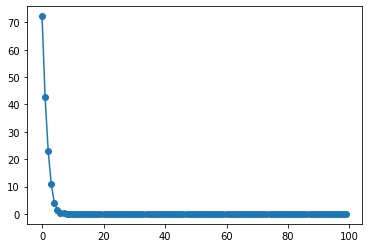

In [61]:
import matplotlib.pyplot as plt

plt.plot(avg_bit_ges, marker='o')
plt.show()

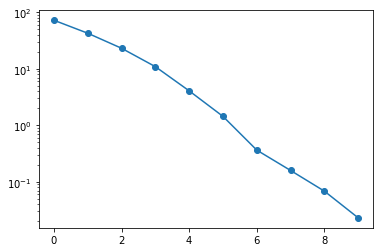

In [62]:
plt.yscale("log")
plt.plot(avg_bit_ges[:10], marker='o')
plt.show()

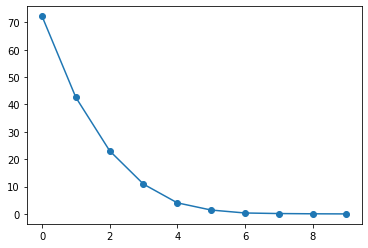

In [63]:
plt.plot(avg_bit_ges[:10], marker='o')
plt.show()

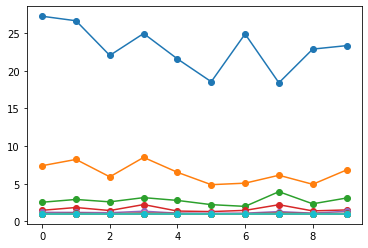

In [64]:
plt.plot(ges[:10], marker='o')
plt.show()

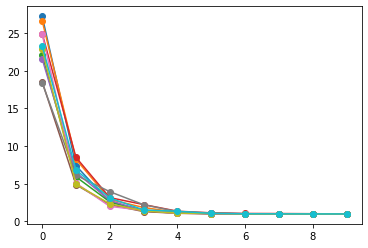

In [65]:
plt.plot(ges.T[:10], marker='o')
plt.show()

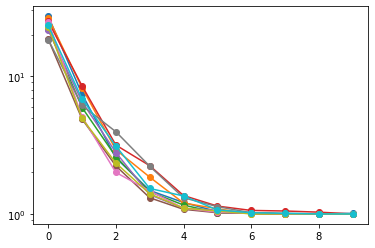

In [66]:
for ge in ges:
    plt.yscale('log')
    plt.plot(ge[:10], marker='o')
plt.show()

In [ ]:
bit_ges_no16 = np.log2(ges)
bit_ges_no16

In [49]:
bit_ges_no16.shape

(10, 100)

In [50]:
avg_bit_ges_no16 = np.mean(bit_ges, axis=0)
avg_bit_ges_no16.shape

(100,)